In [478]:
import numpy as np
import csv
import pandas as pd
from scipy import interpolate
import scipy.io as sio
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn import preprocessing

#import sklearn.gaussian_process.kernels.ConstantKernel as C
import random
import torch

from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
%matplotlib inline
random.seed(33)

In [428]:
epochs=70
alpha = 0.001
lr = 0.001


In [429]:
def plotr(l, r, c1):
    x = np.arange(l,r)
    data = c1[l:r]
    plt.figure(figsize=(15,4))
    plt.plot(x, data)
    if ( r-l < 1000):
        plt.xticks(np.arange(l, r, 10))
    plt.show()
    return

def subplotr(l, r, c,i):
    x = np.arange(l,r)
    data1 = c[l:r, 0]
    data2 = c[l:r, 1]
    #plt.subplot(1,10,i+1)
    plt.figure(figsize=(10,4))
    plt.plot(x, data1)
    plt.plot(x, data2)
    if ( r-l < 1000):
        plt.xticks(np.arange(l, r, 10))
    plt.show()
    return

In [430]:
offset = np.array([[260, 420, 575,725,875,1020,1165,1320,1460,1600,1740,1888,2036,2184,2340,2490,2640,2790,2940,3090], \
                   [360,578,800,1005,1250,1475,1695,1930,2160,2380,2610,2830,3060,3300,3532,3770,4008,4236,4470,4700], \
                   [275, 510, 750, 1000, 1245, 1480, 1710, 1950, 2195, 2430, 2680, 2925, 3160, 3405, 3640, 3890, 4110, 4350, 4590, 4800], \
                   [460, 709, 948, 1200, 1446, 1695, 1930, 2153, 2392, 2621, 2850, 3099, 3330, 3570, 3800, 4045, 4284, 4523, 4762, 5011], \
                   [430, 720, 990, 1260, 1510, 1770, 2040, 2300, 2565, 2830, 3100, 3375, 3655, 3940, 4220, 4500, 4800, 5110, 5430, 5750], \
                   [340, 600, 880, 1175, 1470, 1775, 2080, 2375, 2680, 2960, 3240, 3515, 3790, 4080, 4370, 4655, 4925, 5205, 5500, 5790], \
                   [450, 685, 910, 1125, 1355, 1570, 1800, 2025, 2260, 2480, 2720, 2935, 3180, 3405, 3630, 3845, 4060, 4275, 4485, 4700],
                   [630, 840, 1080, 1310, 1550, 1790, 2020, 2260, 2500, 2750, 2990, 3250, 3500, 3750, 4000, 4260, 4505, 4760, 4990, 5240], \
                   [580, 760, 995, 1220, 1455, 1680, 1905, 2135, 2365, 2590, 2835, 3070, 3305, 3540, 3785, 4020, 4245, 4480, 4705, 4930], \
                   [300, 548, 796, 1044, 1316, 1575, 1838, 2100, 2365, 2627, 2878, 3138, 3400, 3664, 3932, 4200, 4478, 4750, 5000, 5280]]
                 )
geslen = np.array([140, 220, 240, 238, 260, 260, 220, 225, 210, 245])

0 (3421, 2)


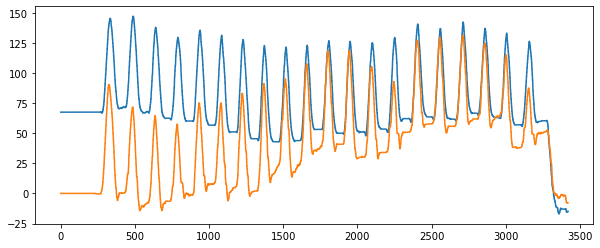

1 (4932, 2)


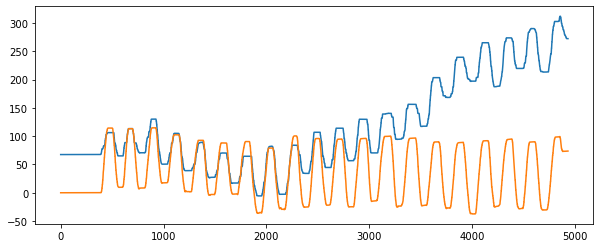

2 (5058, 2)


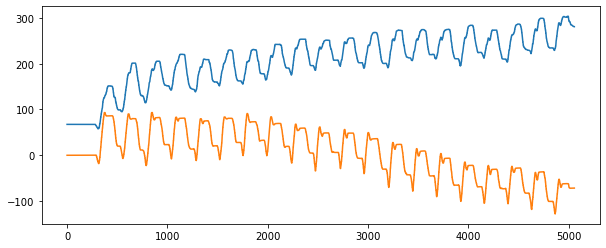

3 (5258, 2)


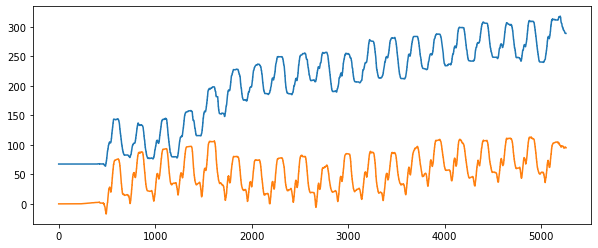

4 (6150, 2)


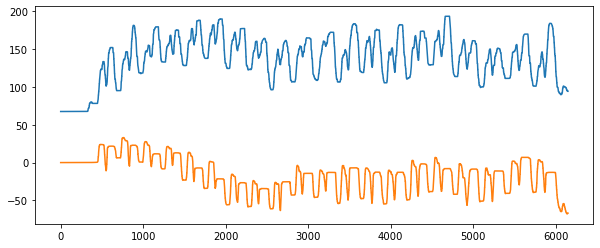

5 (6076, 2)


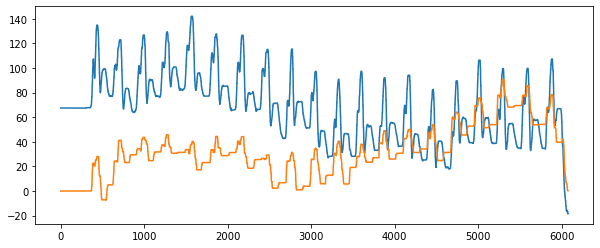

6 (4983, 2)


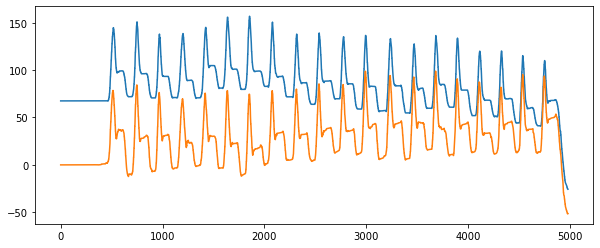

7 (5544, 2)


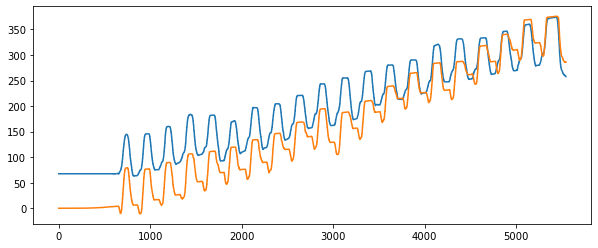

8 (5262, 2)


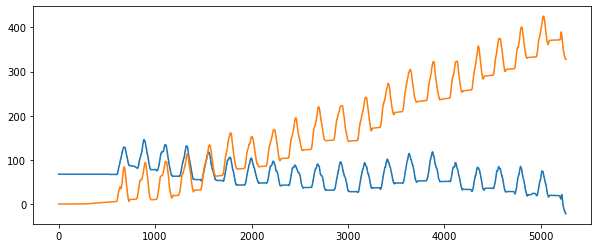

9 (5623, 2)


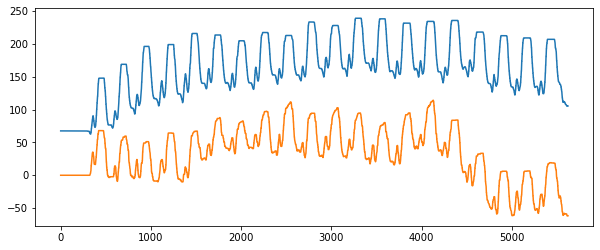

In [431]:
#def showalllines():
#plt.figure(figsize=(20,8))
for i in range(10):
    name='digit'+str(i)
    locals()['digit'+str(i)]=np.loadtxt("digits_trace/digit%1d.txt" % (i))
    print (i, locals()['digit'+str(i)].shape)
    subplotr(0, locals()['digit'+str(i)].shape[0], locals()['digit'+str(i)], i)
#showalllines()       

(4932, 2)


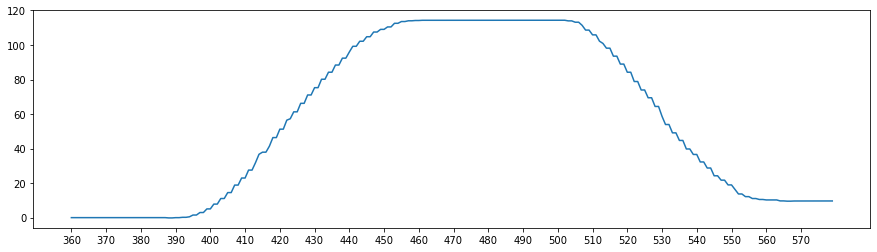

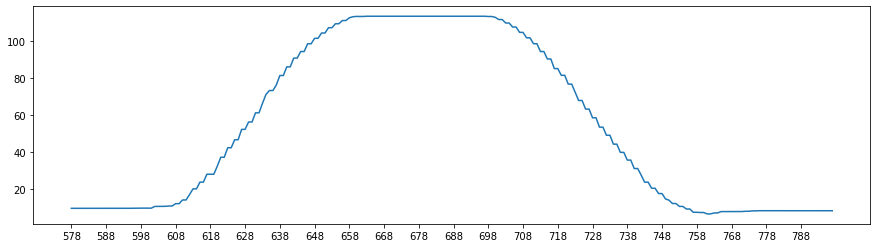

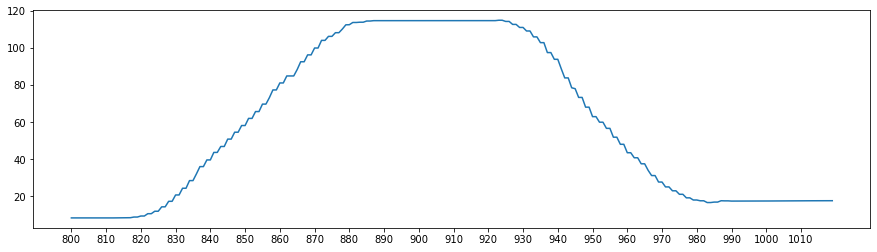

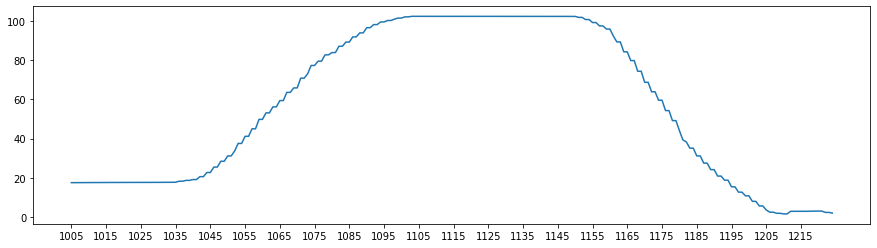

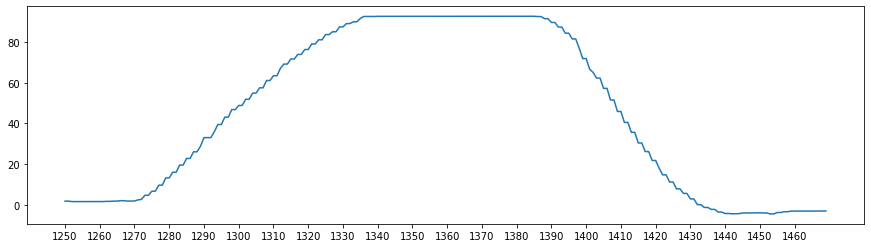

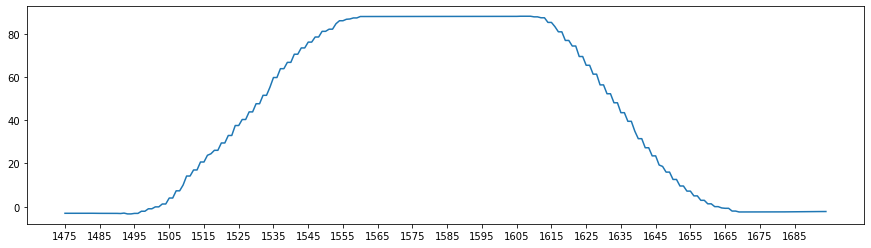

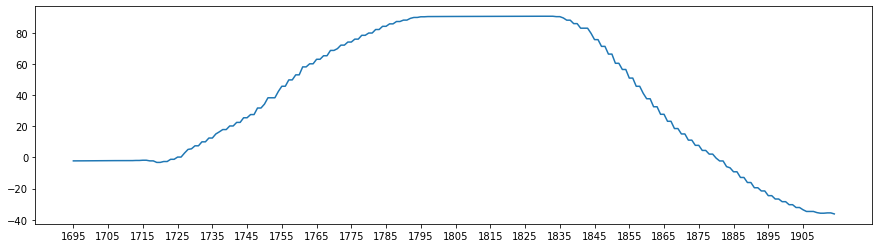

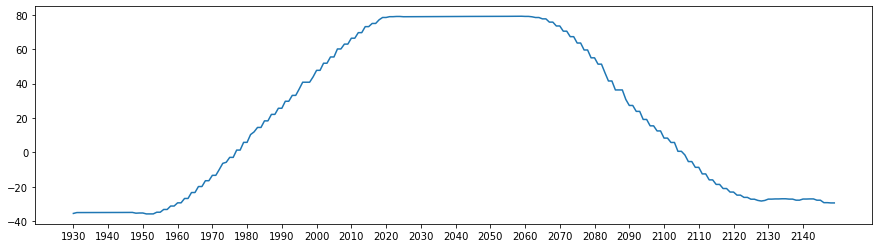

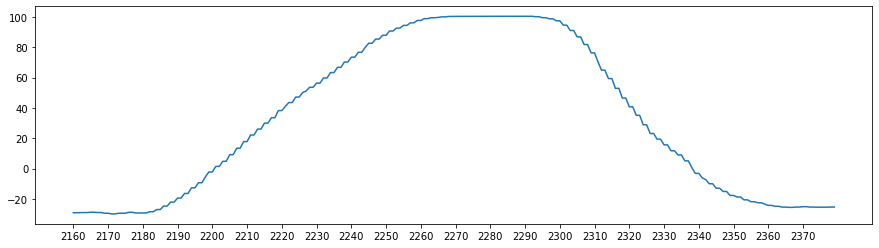

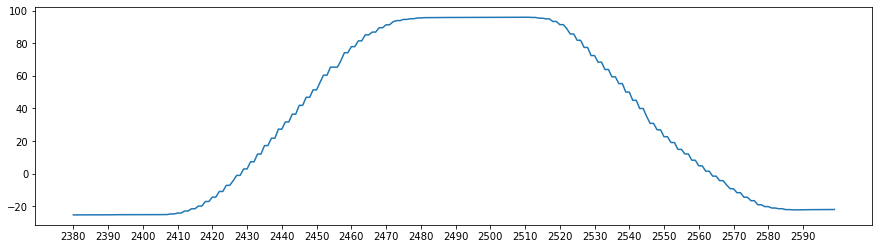

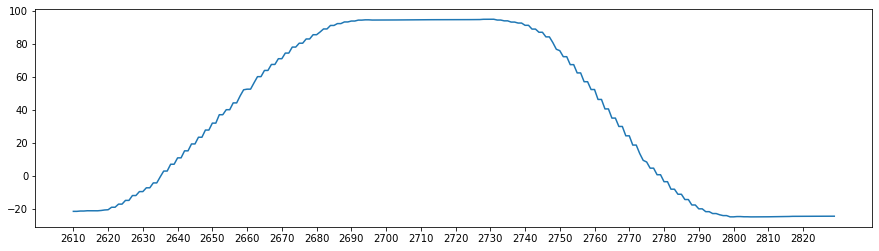

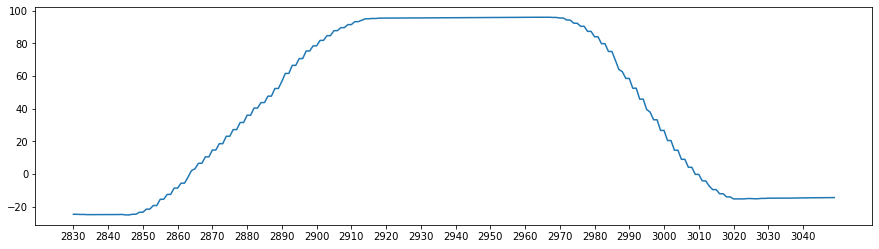

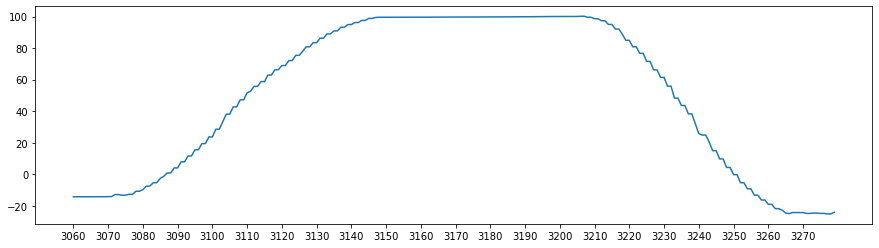

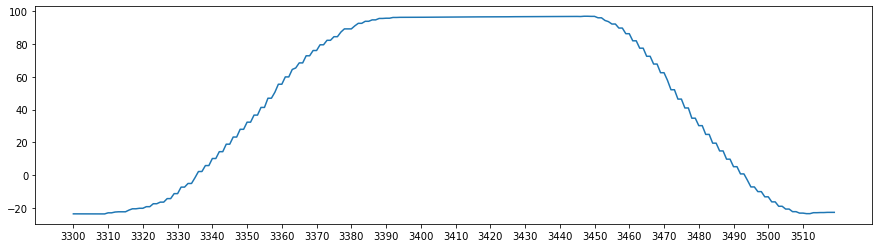

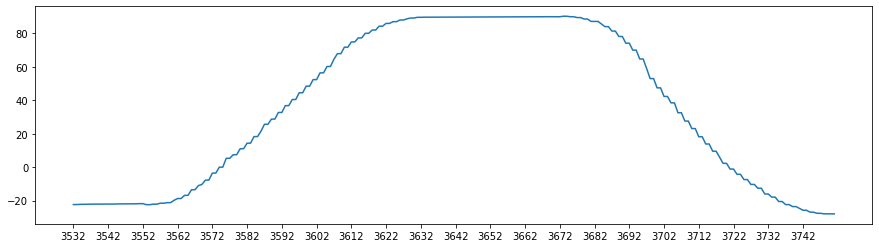

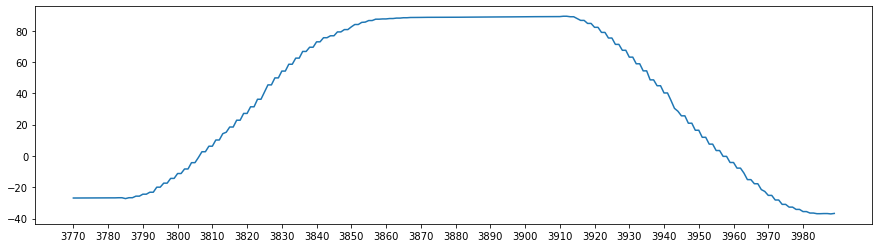

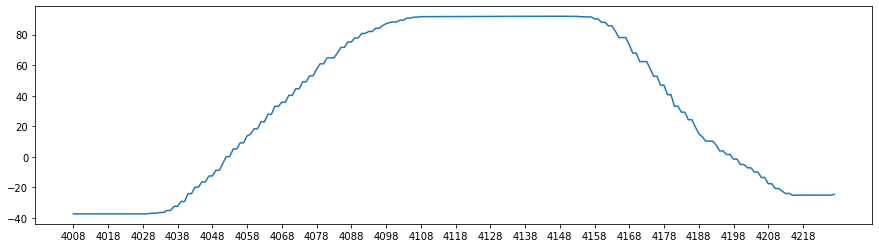

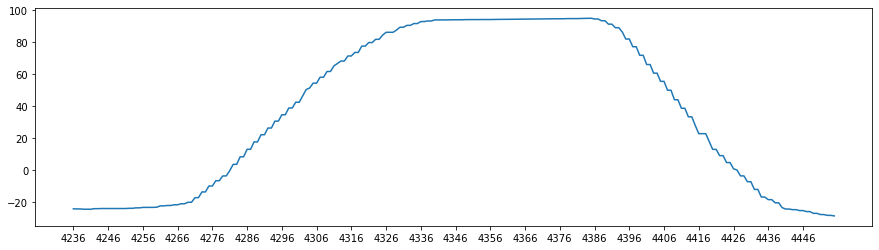

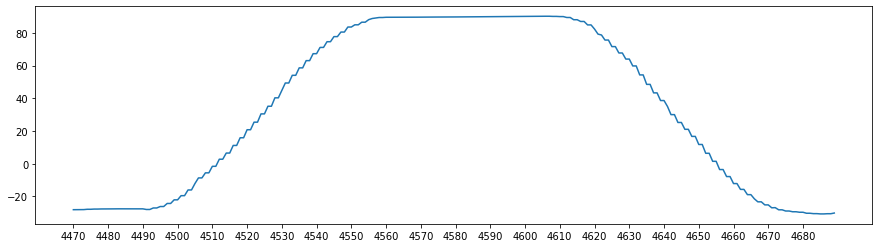

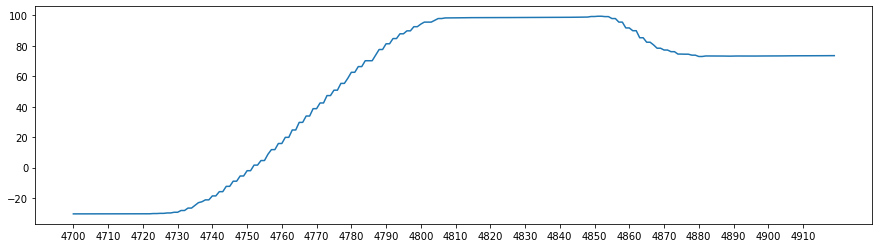

In [442]:
num = 1
digit = digit1
print(digit.shape)
c1 = digit[:, 0]
c2 = digit[:, 1]
#plotr(0, digit.shape[0], c1);
#plotr(0, digit.shape[0], c2);
#for i in range(20):
#    print(" %d," % (300 + i*248), end='')

cc = c2
ll = digit.shape[0]//5;
for i in np.arange(20):
#for i in [2]:
    plotr(offset[num][i], offset[num][i] + geslen[num], cc)

## show digits' sample

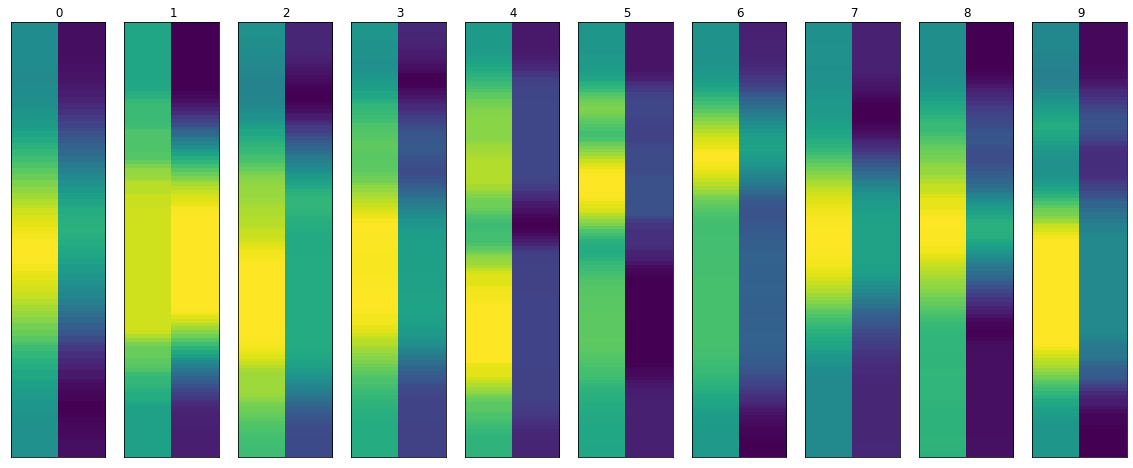

In [433]:
#def showallimage():
samplenum = 0
plt.figure(figsize=(20,8))
for i in range(10):
    rawpic =  locals()['digit' + str(i)]
    ilen = geslen[i];
    ioffset = offset[i][samplenum];
    rawpic = rawpic[ioffset:ioffset+ilen, :]
    pic = rawpic
    ax =plt.subplot(1,10,i+1)
    ax.set_title(" %s" % (i))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(pic, aspect='auto')
#showallimage()

# Interpolate function:

In [434]:
def iinterpolate(y, newlen, boolp=0):
    
    x=np.arange(0, y.shape[0])
    #y=savgol_filter(y, 51, 4)
    xnew=np.arange(0,newlen)/newlen*y.shape[0]
    if (boolp == 1):
        plt.figure(figsize=(20,8))
        plt.plot(x, y, "b.")

    for kind in ["cubic"]:
        #"nearest","zero"为阶梯插值   
        # slinear 线性插值    
        #"quadratic","cubic" 为2阶、3阶B样条曲线插值
        f=interpolate.interp1d(x,y,kind=kind,fill_value="extrapolate")
        ynew=f(xnew)
        #ynew = savgol_filter(ynew, 51, 6)
        if (boolp == 1):
            r=0
            l=newlen
            plt.plot(xnew[r:l],ynew[r:l],label=str(kind))
        #print(ynew.shape)
        
    if (boolp == 1):
        plt.legend(loc="lower right")
        plt.show()
    return ynew

num=6
sample=2
newlen = geslen.max(0)
y=locals()['digit'+str(num)][offset[num][sample]:offset[num][sample] + geslen[num], 0]
#y=savgol_filter(y, 51, 2)
iinterpolate(y , newlen)
plt.figure(figsize=(20,8))
#plt.plot(np.arange(geslen[num]), locals()['digit'+str(num)][offset[num][sample]:offset[num][sample] + geslen[num], 0])

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

## Normalization + Prepare training data

[4.5 0. ]
[[1 8]]
[[0.12403473 0.99227788]]
[[-1  1]]
[[-0.70710678  0.70710678]]
(10, 260, 2)


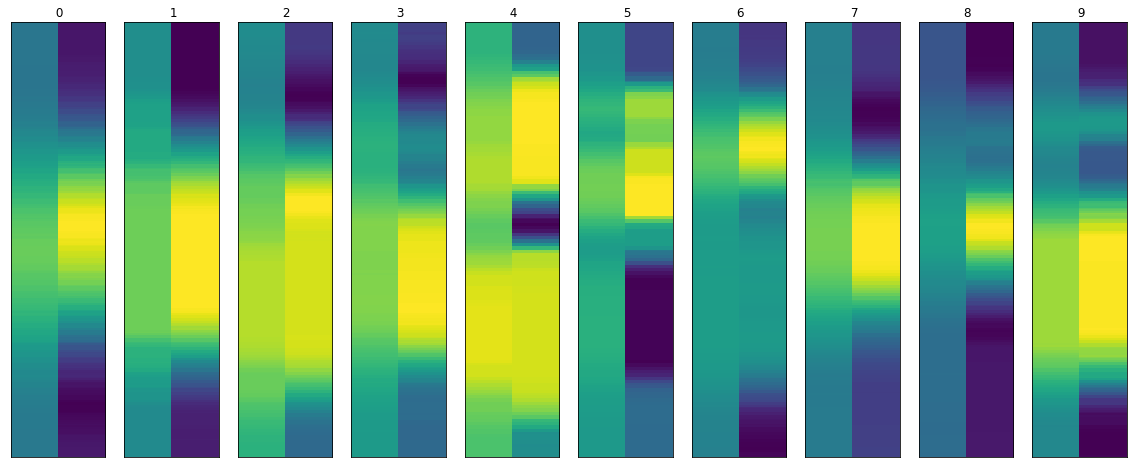

In [504]:


maxlen = geslen.max(0)

plt.figure(figsize=(20,8))

a=np.array([[1,-1],
         [8,1]])
print(a.mean(0))
for i in np.arange(2):
    b = a[:,i].reshape(1,2);
    print(b)
    nb= preprocessing.normalize(b)
    print(nb)



len1=10
len2=1
img = np.zeros((len1*len2, maxlen, 2));
labels = np.zeros(len1*len2)
ltr = 170
lval = 10

print(img.shape)
for i in range(len1):
    for samplenum in range(len2):
        rawpic =  locals()['digit' + str(i)];
        ilen = geslen[i];
        ioffset = offset[i][samplenum];
        #print(ioffset, ilen);
        rawpic = rawpic[ioffset:ioffset+ilen, :];
        #col1 = preprocessing.normalize(rawpic[:, 0].reshape(1,maxlen));
        #col2 = preprocessing.normalize(rawpic[:, 1].reshape(1,maxlen));
        #np.atleast_2d(data['time']).T
        y1 = iinterpolate (rawpic[:, 0], maxlen)
        y2 = iinterpolate (rawpic[:, 1], maxlen)
        y1 = preprocessing.normalize(y1.reshape(1,maxlen))
        y2 = preprocessing.normalize(y2.reshape(1,maxlen))

        pic= np.vstack((y1, y2)).T;
        #print(pic.shape)
        ind = i + samplenum
        img[ind]=pic
        ax =plt.subplot(len2, len1,ind+1)
        ax.set_title(" %s" % (i))
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(img[ind], aspect='auto')
        labels[ind]=i


## MyDataset

(190, 260, 2)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3.
 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7.
 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1.
 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5.
 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9.
 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3.
 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7.
 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
(190,)
190
torch.Size([1, 260, 2])
7
(170,)
(10,)


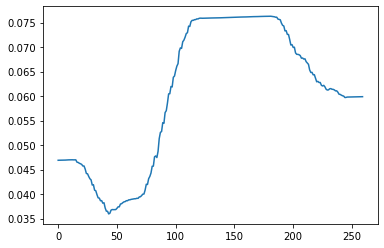

In [492]:
class MyDataset(Dataset): 
            
    def __init__(self, transform=None,target_transform=None):

        super(MyDataset,self).__init__()
                          
    #fh = open(txt, 'r')
                #按照传入的路径和txt文本参数，以只读的方式打开这个文本
    #for line in fh: #迭代该列表#按行循环txt文本中的内
        #   line = line.strip('\n')
        #   line = line.rstrip('\n')
        #                # 删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
        #   words = line.split()
        #              #用split将该行分割成列表  split的默认参数是空格，所以不传递任何参数时分割空格
        #   imgs.append((words[0],int(words[1])))
        #            #把txt里的内容读入imgs列表保存，具体是words几要看txt内容而定 
        #               # 很显然，根据我刚才截图所示txt的内容，words[0]是图片信息，words[1]是lable       
        self.imgs = np.array(img, dtype='float32')
        print(self.imgs.shape)
        self.transform = transform
        self.target_transform = target_transform
        self.labels = np.array(labels, dtype='int64')
        print(labels)
        print(labels.shape)

    def __getitem__(self, index):
        #fn = torch.from_numpy
        label = self.labels[index]
        img = self.imgs[index]
                          # 按照路径读取图片
        if self.transform is not None:
            img = self.transform(img) 
                                #数据标签转换为Tensor
        return img, label

    def __len__(self):
        return len(self.imgs)
    

train_data=MyDataset( transform=transforms.ToTensor())
#test_data = MyDataset( transform=transforms.ToTensor())
print(len(train_data))
train_set, val_set, test_set = torch.utils.data.random_split(  train_data,[int(ltr), int(lval), int( len(train_data) -ltr - lval) ] )

#print(train_data.__len__)
print(train_set[0][0].shape)
yy= train_set[0][0][0][:,1]
plt.plot(np.arange(260), yy)
print(train_set[0][1])
print(train_set[:][1].shape)
print(test_set[:][1].shape)

#plt.figure(figsize=(20,8))
#print(len(train_set))
for i in np.arange(9):
    #print(i)
    pic = transforms.ToPILImage()(train_set[i][0])
    #plt.subplot(2,9,i+1)
    #plt.title("Original label : %d" %(train_set[i][1]))
    #plt.imshow(pic, aspect='auto')
    #plt.subplot(2,9, i+1+9)
    #plt.imshow(train_set[i][0],aspect='auto')
    


In [493]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

## TrainModel

In [494]:
def TrainModel(model, alpha, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=alpha)
    
   # if torch.cuda.is_available():
    #    model = model.cuda()
    #    criterion = criterion.cuda()
     
    best_epoch = 0
    best_val_loss = 10
    e_vloss = []
    e_trloss = []
    e_vaccu = []
    
    for epoch in range(epochs):
        trloss = 0
        vloss = 0

# train model
        model.train()
        for itr, (image, label) in enumerate(train_loader):
            #print(label.type())
            #print(label)
            optimizer.zero_grad()
            predic = model(image)
            loss = criterion(predic, label)
            trloss += loss.item()
# backforward 
            loss.backward()
            optimizer.step()
        
        trloss = trloss / (itr + 1)
        e_trloss.append(trloss)

# validation
        model.eval()
        total = 0
        for itr, (image, label) in enumerate(val_loader):
             
            predic = model(image)
            loss = criterion(predic, label)
            vloss += loss.item()

            for i, p in enumerate(predic):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(val_set)
        e_vaccu.append(accuracy)
        vloss = vloss / (itr + 1)
        e_vloss.append(vloss)

        if vloss < best_val_loss:
            best_epoch = epoch
            best_val_loss = vloss
            torch.save(model.state_dict(), "bestmodel")
    
    print('Best epoch : %d' % (best_epoch))
    return e_vloss, e_trloss, e_vaccu

## TestModel

In [499]:
results=[]
def TestModel(model):
    #if torch.cuda.is_available():
    #    model = model.cuda()
        
    model.load_state_dict(torch.load("bestmodel"))
    

# calculate accuracy
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(test_loader):
        print(label.type())
        print(label)
        predic = model(image)
        for i, p in enumerate(predic):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
            results.append((image, torch.max(p.data, 0)[1]));
    test_accuracy = total / len(test_set)
    print('Test accuracy : %f'%(test_accuracy))
    
    fig = plt.figure(figsize=(12,9))
    for i in range(10):
        img=results[0][0][i][0].cpu()
        fig.add_subplot(3, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("predic : %d" %(results[i][1].item()) )
        plt.imshow(img, aspect='auto')

    return test_accuracy

## CNN layers

Best epoch : 18
torch.LongTensor
tensor([2, 0, 9, 1, 1, 5, 6, 0, 6, 3])
Test accuracy : 0.800000


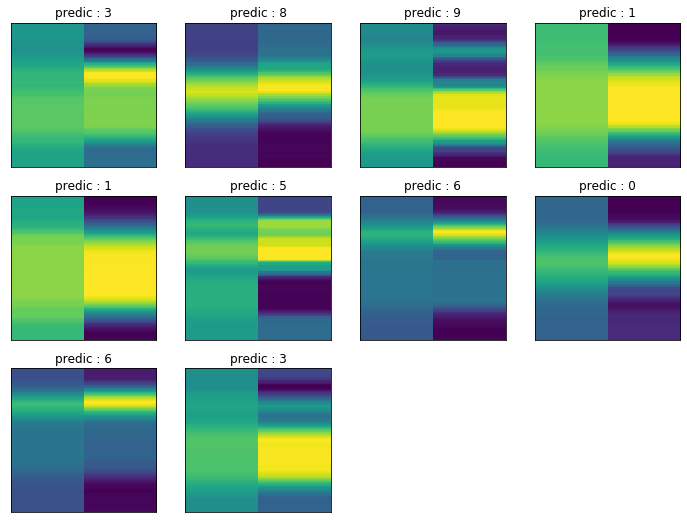

In [500]:
class cnn_l2_semi(nn.Module):
    def __init__(self):
        super(cnn_l2_semi, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(2*260*32, 512)
        self.linear_2 = nn.Linear(512, 10)
        self.active = nn.ReLU6()
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        x = self.conv_1(x)
        x = self.active(x)
        #x = self.pool(x);
        
        x = x.reshape(x.size(0), -1)
        
        x = self.linear_1(x)
        x = self.active(x) 
        x = self.dropout(x)
        x = self.linear_2(x)
        return x
    
epochs=50
cnn_l2_semi_vloss, cnn_l2_semi_trloss, cnn_l2_semi_vaccu = TrainModel(cnn_l2_semi(),alpha, epochs)
cnn_l2_semi_taccu = TestModel(cnn_l2_semi())

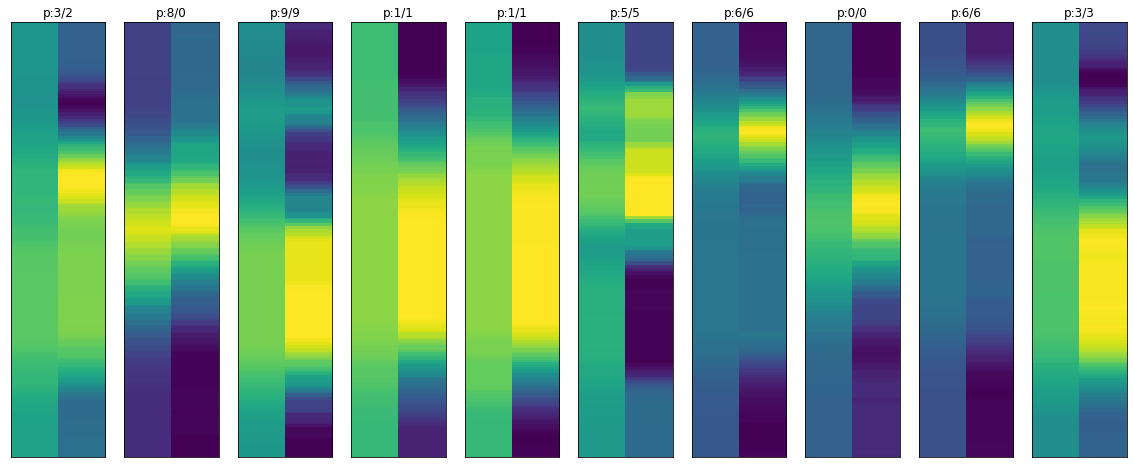

In [509]:
actual = np.array([2, 0, 9, 1, 1, 5, 6, 0, 6, 3])
fig = plt.figure(figsize=(20,8))
for i in range(10):
    img=results[0][0][i][0].cpu()
    fig.add_subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("p:%d/%d" %(results[i][1].item(), actual[i]) )
    plt.imshow(img, aspect='auto')

## Local GP

In [305]:
def localgp(l1, l2):
    data = c1[l1:l2];
    xtime = np.atleast_2d(np.arange(l1, l2)).T

    #print(xmesh.size)
    #xdata = np.atleast_2d(data).T

    #kernel = ConstantKernel(3, (1e-2, 20)) * (RBF(10, (1e-2, 20))) + WhiteKernel(1, (1e-2, 5))
    kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) \
           * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) \
        + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0));
    kernel = ConstantKernel(1, (0.001,0.1))*RBF(1,(1e-4,10)) 
    gp = GaussianProcessRegressor(kernel=kernel)   #, n_restarts_optimizer=9)
    
    params = gp.kernel.get_params()
    gp.fit(xtime, data);
    y_pred, sigma = gp.predict(xtime, return_std=True);

    params = gp.kernel_.get_params()
    print(params)
    f = params.get('k1__constant_value')
    l = params.get('k2__length_scale')
    #n = params.get('k2__noise_level')
    print(f)
    print(l)
    #print(n)
    conf = 1
    #plt.figure()
    plt.title('%5f    %5f'% (f,l))
    plt.plot(xtime, data, 'o', color='b',markerfacecolor='none', label='Trajectory')
    plt.plot(xtime, y_pred, color='black', label='Prediction')
    plt.fill(np.concatenate([xtime, xtime[::-1]]),
         np.concatenate([y_pred - conf*sigma,
                        (y_pred + conf*sigma)[::-1]]), alpha=.5, fc='lightgray',ec='None', label='95% confidence')
    #plt.xlabel('elapsed_time')
    #plt.title('Global fitting: use 5 trails:1, 2, 3, 4, 5.')
    #plt.ylabel('3_x')
    #plt.legend(loc='lower left',prop={'size': 8})
    plt.show()
    er = sum((y_pred-data)**2)/y_pred.size
    print(er)
    return ;
#y_pred, sigma, f, l, n